# Kaggle - Baseball Analysis
https://www.kaggle.com/gracezhou0912/baseball-analysis?scriptVersionId=333221

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
# read data
player = pd.read_csv("./data/player.csv") # 每1年，球員的個人資料(姓名、出生、隊伍、守備位置.....)
salary = pd.read_csv("./data/salary.csv") # 每1年，每1隊，球員的薪資 (year、team_id、league_id、player_id、salary)

team =  pd.read_csv("./data/team.csv")    # 每1年，球隊數據、排名
fielding = pd.read_csv("./data/fielding.csv") # 每1年，球員守備數據

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Salary between leagues and year

Text(0.5, 1.0, 'Baseball player salary over years')

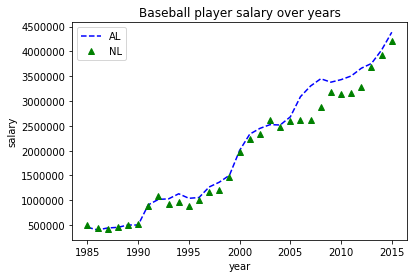

In [2]:
## 多層次index(multiindex) 變成 column 用 unstack
data = salary.groupby(["year","league_id"]).mean().unstack().copy(deep = True)

# see the salary trend
plt.plot(data["salary"]["AL"], 'b--', data["salary"]["NL"], 'g^')
plt.xlabel("year")
plt.ylabel("salary")
plt.legend(["AL","NL"], loc = "leftup")
plt.title("Baseball player salary over years")

### Salary between different positions and age

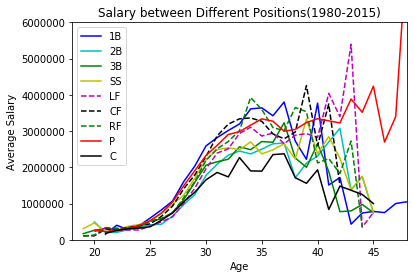

In [3]:
# Salary between different positions and age

warnings.filterwarnings('ignore')

#合併欄位，用 player_id、year合併： 守備位置 、 薪資
player_position = pd.merge(salary, fielding, on = ["player_id","year"])[["year", "player_id", "salary", "pos"]]
#合併欄位，再用 play_id : 守備位置、薪資、球員個人資料
player_position = pd.merge(player_position, player, on = ["player_id"], how = "left")[["year", "player_id","salary", "pos", "birth_year"]]

# 計算球員年紀
player_position["age"] = player_position["year"] - player_position["birth_year"] 

#並篩出1980年之後之資料
player_position = player_position[player_position.year >= 1980]

# multiindex to columns：用　pd.unstack()
data = player_position.groupby(["age", "pos"]).mean()["salary"].unstack()

#plt.plot(data["1B"],  data["2B"], data["3B"], data["C"], data["CF"], data["LF"], data["P"], data["RF"], data["SS"])
plt.plot(data["1B"], 'b-', data["2B"], 'c-', data["3B"], 'g-', data["SS"], 'y-',data['LF'], 'm--', data['CF'], 'k--', data['RF'], 'g--', data['P'],'r-', data['C'],'k-')
_ = plt.xlabel("Age")
_ = plt.ylabel("Average Salary")
_ = plt.legend(["1B",'2B','3B','SS',"LF","CF","RF","P","C"], loc = 'leftup')
_ = plt.title("Salary between Different Positions(1980-2015)")
_ = plt.xlim([18,48])
_ = plt.ylim([0,6000000])

### Is there a most error prone position?
### 各守備位置 每1場比賽失誤次數

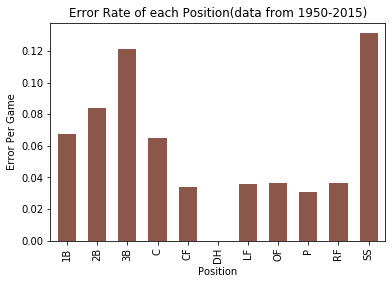

In [12]:
# 篩選1950以後之資料，並篩出需要的欄位
data = fielding[fielding["year"] >= 1950][["year","team_id","player_id","pos", "g","e"]]
# 剔除出場數為 0 之資料
data = data[data["g"] != 0]
# 計算每個守備位置每1場比賽失誤次數的平均值
data.loc[:,"error/game"] = data["e"]/data["g"]
error_data = data.groupby("pos").mean()["error/game"]

# 把 Series 轉 DataFrame：用 Series.to_frame()
error_data = error_data.to_frame()

# 用 pandas 繪製直方圖
p1 = error_data["error/game"].plot.bar(figsize = (6,4), width = .6, color = sns.color_palette()[5])
_ = p1.set(title = "Error Rate of each Position(data from 1950-2015)")
_ = p1.set(xlabel = "Position", ylabel = "Error Per Game")
# We can see that the most error prone position is SS followed by 3B
# generally speacking, OF are less error prone

### Are the best performers selected for all-star game?
### 表現越佳，越會被選入明星球員??

Text(0.5, 1.0, 'How many All-Stars are from Top 100 Performance Players')

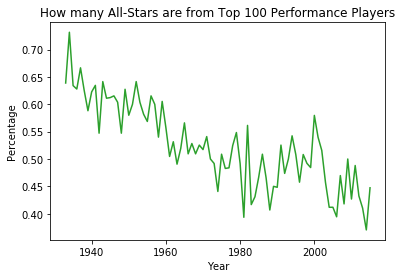

In [17]:
# 守備數據處理
# combine fielding and post-fielding (from 1933)
all_star = pd.read_csv("./data/all_star.csv")[["player_id","year"]] # 入選明星球員數據
fielding = pd.read_csv("./data/fielding.csv") # 讀守備數據
fielding_postseason = pd.read_csv("./data/fielding_postseason.csv") # 讀季後賽守備數據
fielding = fielding[fielding["year"] >= 1933] # 篩選1993年以後資料
fielding_postseason = fielding_postseason[fielding_postseason["year"] >= 1933] # 篩選1993年以後資料
all_fielding = pd.concat([fielding, fielding_postseason], axis = 0) # 垂直合併欄位
all_fielding = all_fielding.groupby(["year","player_id"]).sum()[["g", "gs", "inn_outs", "po","a","e","dp","pb"]]
all_fielding = all_fielding.fillna(0) # 漏失值補零

# 計算守備率(FP): 刺殺、助殺之合計除以刺殺、助殺、失誤的合計數。
# calculate fielding percentage: (Putouts + Assists) divided by (Putouts + Assists + Errors)
# po: Putouts / Pickoff ; a: Assist ; e: Error ; dp: Double Play; pb: Passed Balls
all_fielding["FP"] = (all_fielding["po"] + all_fielding["a"])/(all_fielding["po"] + all_fielding["a"] + all_fielding["e"])

# 選手出席賽數 至少要大於整體平均值
# we don't consider those who participated less than mean_game
mean_game = all_fielding["g"].mean()
all_fielding = all_fielding[all_fielding["g"] >= mean_game]

# 打擊數據處理
# combine batting and batting_postseason
# ab: At Bats; bb: walk-to-strikeout ; double;  triple ; r : runs ; rbi :Run batted in　；
# h : hits ; hr : home run ; sb: Stolen bases; tb = 2*double + 3*triple + 4*home run
# g_idp : 	Double play ; cs : Caught Stealing
batting = pd.read_csv("./data/batting.csv")  # 讀打擊數據
batting_postseason = pd.read_csv("./data/batting_postseason.csv") # 讀季後賽打擊數據
batting = batting[batting["year"] >= 1933] # 篩選1993年以後資料
batting_postseason = batting_postseason[batting_postseason["year"] >= 1933] # 篩選1993年以後資料
all_batting = pd.concat([batting, batting_postseason], axis = 0) # 垂直合併欄位
all_batting = all_batting.groupby(["year","player_id"]).sum()[["g","h", "double", "triple", "hr", "sb", "bb","ab","g_idp","cs"]]
all_batting = all_batting.fillna(0) # 漏失值補零

#打擊指標
# Total Average = (h + double + 2*triple + 4*hr + sb + bb)/(ab - h + g_idp + cs)
all_batting["TA"] = (all_batting["h"] + all_batting["double"] + 2*all_batting["triple"] + 4*all_batting["hr"] + all_batting["sb"]+all_batting["bb"])/(all_batting["ab"]- all_batting["h"]+all_batting["g_idp"]+all_batting["cs"])
# 選手出席賽數 至少要大於整體平均值
# we don't consider those who participated less than mean_game
all_batting = all_batting[all_batting["g"] >= mean_game]

# 投手數據處理
# combine pitching and pitching_postseason
pitching = pd.read_csv("./data/pitching.csv")
pitching_postseason = pd.read_csv("./data/pitching_postseason.csv")
pitching = pitching[pitching['year'] >= 1993]
pitching_postseason = pitching_postseason[pitching_postseason['year'] >= 1993]
all_pitching = pd.concat([pitching, pitching_postseason], axis = 0)
all_pitching.groupby(["year","player_id"])

# 同時考量守備數據、打擊數據，決定表現好的球員
# combine fielding percentage and batting average to determine the performance of a player
data1 = all_fielding["FP"] # 篩出守備率
data2 = all_batting["TA"] #篩出打擊指標
data1 = data1.reset_index(level = ['year','player_id'])
data2 = data2.reset_index(level = ['year','player_id'])

#合併每個選手的打擊、守備數據
data = pd.merge(data1, data2, on =['year','player_id'], how = 'inner')
#綜合考量 "Score" = 'FP' + 'TA'
data["Score"] = data['FP'] + data['TA']

year_range = list(range(1933, 2016))
percentage = pd.Series()
i = 0
for year in year_range:
    stars = all_star[all_star['year'] == year]
    star_count = len(stars.index)
    df = data[data['year'] == year]
    df = df.fillna(0)
    df = df[["year","player_id", "Score"]]
    df["rank"] = df['Score'].rank(ascending = False)
    df = df[np.isfinite(df['Score'])]
    df = df[df['rank'] <= 100]
    
    hs = set()
    count = 0
    
# 1年份所有球員名單塞入 set ，移除重覆
    for name in df["player_id"]:
        hs.add(name)
# 計算所有球員名單中，有入選明星球員之人次
    for name in stars["player_id"]:
        if name in hs:
            count = count + 1
#將每年之資料填入 Series 裡
    percentage.set_value(i, count/star_count)
    i = i+1

plt.plot(year_range, percentage, color = sns.color_palette()[2])
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.title("How many All-Stars are from Top 100 Performance Players")
# There are several possible reasons for this situation:
# 1. The performance formula is not scientific
# 2. Because of Internet vote, all-star game players are selected for their fame rather than performance.

### Do players with a high ground into double play (GIDP) have a lower batting average?
### 被雙殺率 與 打擊率低迷 有關嗎?
### (還沒研究)

In [18]:
# Do players with a high ground into double play (GIDP) have a lower batting average?
# batting average = h/ab
warnings.filterwarnings('ignore')

# 球員 打擊數據
batting = pd.read_csv("./data/batting.csv")
batting_postseason = pd.read_csv("./data/batting_postseason.csv")
all_batting = pd.concat([batting, all_batting], axis = 0)
all_batting = all_batting.groupby(["year","player_id"]).sum()[["ab", "h", "g_idp"]]
all_batting = all_batting[np.isfinite(all_batting['g_idp'])]
all_batting = all_batting[(all_batting["ab"] != 0) & (all_batting["g_idp"]!= 0)]
all_batting["batting_average"] = all_batting["h"]/all_batting["ab"]

# 用簡單線性迴歸
from sklearn.linear_model import LinearRegression

algorithm = LinearRegression()
predictors = ["g_idp"]

#Initiate our algorithm class
algorithm = LinearRegression()
predictors = all_batting[predictors]
# The target we're using to train the algorithm.
target = all_batting["batting_average"]
# Training the algorithm using the predictors and target.
algorithm.fit(predictors, target)
print('Coefficients: \n', algorithm.coef_)
# From regression, we can see that the coefficient is not negative, thus the assumption is not appropriate

Coefficients: 
 [0.0053944]


Text(0.5, 1.0, "Players' G_IDP vs Batting Average")

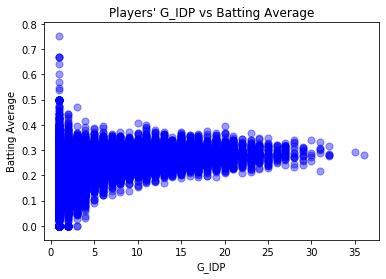

In [19]:
# Let's draw the scatter plot
s = 100
plt.scatter(predictors, target, color='b', s=s/2, alpha=.4)
plt.xlabel("G_IDP")
plt.ylabel("Batting Average")
plt.title("Players' G_IDP vs Batting Average")
# from the plot, there is no evidence that high g_idp will cause low batting average.
# However, the std of batting average decreases as G_IDP increases

### 每個守備位置的生涯尖峰
### When do players at different positions peak?
### (還沒研究)

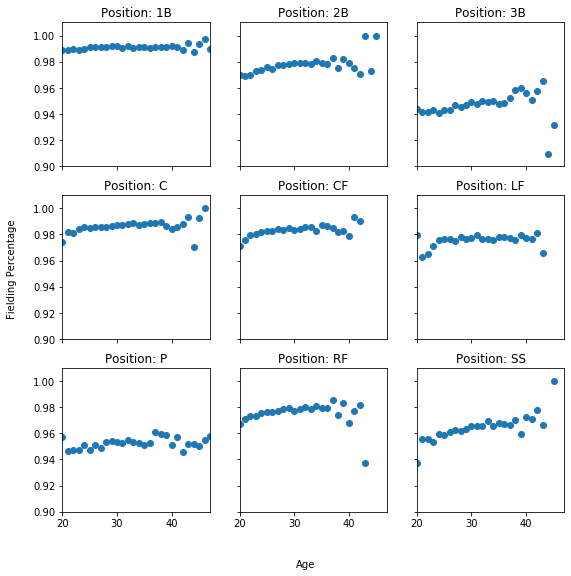

In [21]:
# 1. Consider Fielding Percentage
all_fielding = pd.concat([fielding, fielding_postseason], axis = 0)
all_fielding = pd.merge(all_fielding, player, on = ["player_id"], how = "left")[["year","g","player_id","birth_year","pos", "po","a","e"]]
all_fielding["age"] = all_fielding['year'] - all_fielding['birth_year']
all_fielding["FP"] = (all_fielding["po"] + all_fielding["a"])/(all_fielding["po"] + all_fielding["a"] + all_fielding["e"])
all_fielding = all_fielding[all_fielding["g"]>= 10]
all_fielding = all_fielding.groupby(["pos", "age"]).mean()[["FP"]]
all_fielding = all_fielding.reset_index(level=['pos', 'age'])
positions = ['1B', '2B', '3B', 'C', 'CF', 'LF', 'P', 'RF', 'SS']

fig, axes = plt.subplots(nrows=3, ncols=3, sharex = True, sharey = True, figsize=(9, 9))
fig.text(0.5, 0.04, 'Age', ha='center')
fig.text(0.04, 0.5, 'Fielding Percentage', va='center', rotation='vertical')
axes = axes.ravel()
for i in range(9):
    data = all_fielding[all_fielding["pos"] == positions[i]]
    axes[i].scatter(data["age"], data["FP"], color = sns.color_palette()[0])
    axes[i].set_xlim(20,47)
    axes[i].set_ylim(0.90, 1.01)
    axes[i].set_title("Position: " + positions[i])